In [1]:
#importing Libraries
import ast
import pandas as pd
from datasets import load_dataset
import matplotlib.pyplot as plt

#Loading Data
dataset = load_dataset('lukebarousse/data_jobs')
df = dataset['train'].to_pandas()

#Data Cleanup
df['job_posted_date'] = pd.to_datetime(df['job_posted_date'])
df['job_skills'] = df['job_skills'].apply(lambda x: ast.literal_eval(x) if pd.notna(x) else x)

#Filter data for Data Analyst data
df_DA = df[df['job_title_short'] == 'Data Analyst'].copy()

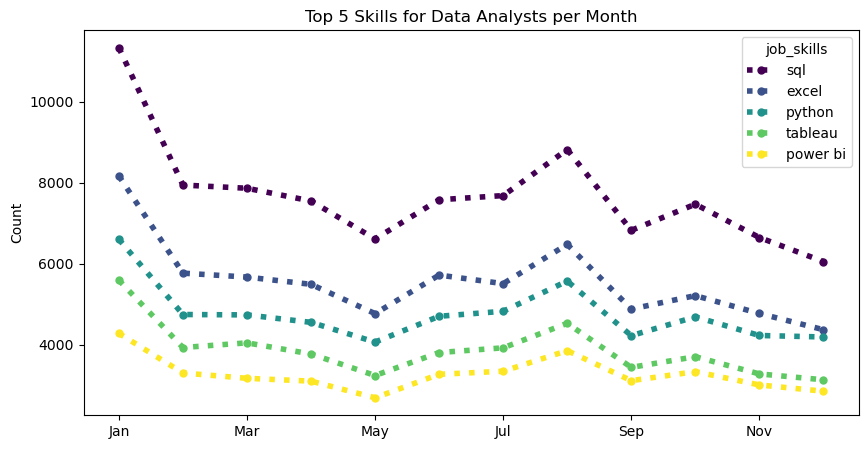

In [13]:
# create a new column for month number
df_DA['job_posted_month_no'] = df_DA['job_posted_date'].dt.month

# Explode the job_skills column and pivot
df_DA_explode= df_DA.explode('job_skills')
df_DA_pivot = df_DA_explode.pivot_table(index='job_posted_month_no', columns='job_skills',  aggfunc='size', fill_value=0)

# sort the skills by count
df_DA_pivot.loc['Total'] = df_DA_pivot.sum()
df_DA_pivot = df_DA_pivot[df_DA_pivot.loc['Total'].sort_values(ascending=False).index]
df_DA_pivot = df_DA_pivot.drop('Total')

# Use month names for plotting
df_DA_pivot = df_DA_pivot.reset_index()
df_DA_pivot['job_posted_month'] = df_DA_pivot['job_posted_month_no'].apply(lambda x: pd.to_datetime(x, format='%m').strftime('%b'))
df_DA_pivot = df_DA_pivot.set_index('job_posted_month')
df_DA_pivot = df_DA_pivot.drop(columns='job_posted_month_no')

# Get the top 5 skills
df_DA_pivot.iloc[:, :5].plot(
    kind='line',
    linewidth = 4,
    linestyle = ':', #Options: '-', '--', '-.', ':'
    colormap='viridis', # options: 'viridis', 'plasma', 'inferno', 'magma', 'cividis' 
    markersize=5,
    marker='o', # options: 'o', 'x', '+', '*', 's', ',', '.', '1', '2', '3', '4', ...
    figsize=(10, 5)
)

plt.title('Top 5 Skills for Data Analysts per Month')
plt.ylabel('Count')
plt.xlabel('')
plt.show()

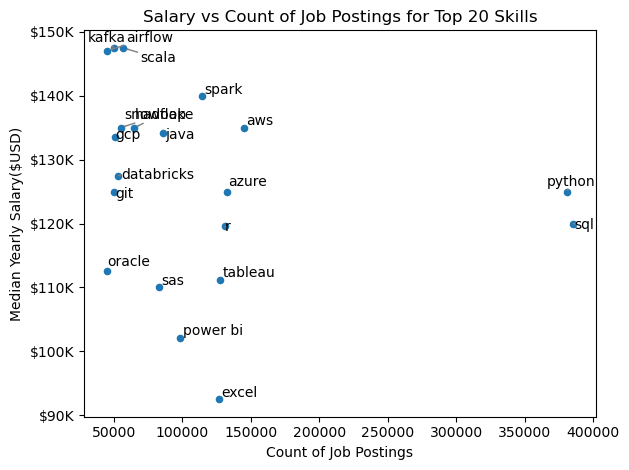

In [35]:
from adjustText import adjust_text

df_exploded = df.explode('job_skills')
skill_stats = df_exploded.groupby('job_skills').agg(
                skill_count = ('job_skills', 'count'),
                median_salary = ('salary_year_avg', 'median')
              )

skill_stats = skill_stats.sort_values(by='skill_count', ascending = False).head(20)

# fig, ax = plt.subplots()

skill_stats.plot(kind = 'scatter', x = 'skill_count', y = 'median_salary')

texts = []
for i, txt in enumerate(skill_stats.index):
    texts.append(plt.text(skill_stats['skill_count'].iloc[i], skill_stats['median_salary'].iloc[i], txt))

adjust_text(texts, arrowprops = dict(arrowstyle = "->", color = 'gray', lw = 1))
ax = plt.gca()
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, pos: f'${int(y/1000)}K'))

plt.xlabel('Count of Job Postings')
plt.ylabel('Median Yearly Salary($USD)')
plt.title('Salary vs Count of Job Postings for Top 20 Skills')
plt.tight_layout()


plt.show()
